In [ ]:
from dotenv import load_dotenv
from IPython.display import display, Image

from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from langchain_core.tools.retriever import create_retriever_tool

# For QA-Retriever
from langchain_core.prompts import PromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain

# Custom Import
from optcg.vectorstore_logic import check_for_updates_to_rules, create_or_load_vectorstore_optcg_rulebooks

from langsmith import traceable
from langsmith.wrappers import wrap_openai
from openai import OpenAI
openai_client = wrap_openai(OpenAI())

_ = load_dotenv() # Loads the .env file - e.g. the OPENAI_API_KEY

In [12]:
vectorstore = create_or_load_vectorstore_optcg_rulebooks()

Loading existing vector store...


In [8]:
# Create the retriever tool directly
rulebook_retriever_tool = create_retriever_tool(
    retriever=vectorstore.as_retriever(), 
    name="rulebooks_retriever",
    description="""Retrieves relevant information from the One Piece TCG rulebooks. This tool is useful for answering questions about the rules of the game, such as how to play, what cards do, and how to resolve specific situations. This is a retrieval tool that will return relevant document chunks from the vectorstore, which contains the rulebooks of the One Piece TCG."""
)

rulebook_retriever_tool

Tool(name='rulebooks_retriever', description='Retrieves relevant information from the One Piece TCG rulebooks. This tool is useful for answering questions about the rules of the game, such as how to play, what cards do, and how to resolve specific situations. This is a retrieval tool that will return relevant document chunks from the vectorstore, which contains the rulebooks of the One Piece TCG.', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x000001DB9CBC2B60>, retriever=VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x000001DB9CDBEC10>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x000001DB9CC00180>, retriev

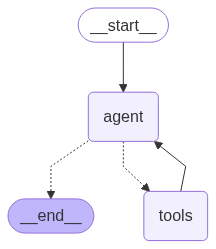

In [13]:
tools = [rulebook_retriever_tool]

@traceable
def build_agent():
    """Builds the agent with the tools and prompt."""
    return create_react_agent(
        model=ChatOpenAI(model="gpt-4.1", temperature=0),
        name="RulebookAgent",
        tools=tools, 
        prompt="You are a helpful assistant that helps people find information in the Rulebook for One Piece TCG, otherwise abbreviated as optcg. You have access to the following tools: {tools}. Use them to find the information the user is looking for. If you don't know the answer, just say you don't know. Do not try to make up an answer. If you cannot find the answer in the rulebooks, tell the user that you cannot find the answer in the rulebooks.",
    )

agent = build_agent()
display(Image(agent.get_graph().draw_mermaid_png()))  # Display the agent's graph structure in Mermaid format

In [14]:
response = agent.invoke(
    {"messages": [{
        "role": "user", 
        "content": "What happens if two characters with the same name are played on the same team?"
    }]}
)
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What happens if two characters with the same name are played on the same team?
================================== Ai Message ==================================
Name: RulebookAgent
Tool Calls:
  rulebooks_retriever (call_MYtqFvcTgVEVTX3XdWwyEzjL)
 Call ID: call_MYtqFvcTgVEVTX3XdWwyEzjL
  Args:
    query: Can two characters with the same name be played on the same team?
================================= Tool Message =================================
Name: rulebooks_retriever

distinguished from one another, a player may be instructed to change sleeves or remove 
them. 
• Players are not allowed to use sleeves that obstruct the front of the card. 
• Sleeves with reflective backs or holographic fronts are not allowed. 
• Sleeves with artwork on the backs, provided all sleeves are identical and are of a non- 
offensive nature, are allowed. 
Players are responsible for ensuring that cards and sleeves are indist